### Predicting cloud task execution time

#### Data set
- Cloud Computing Performance Metrics: https://www.kaggle.com/datasets/abdurraziq01/cloud-computing-performance-metrics
- Dataset contains performance metrics in cloud environment: CPU usage, memory usage, network traffic, energy consumption, number of executed instructions, execution time, energy efficiency, task type, task priority and task status

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("vmCloud_data.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp'])
df = df.sort_values(by='timestamp').reset_index(drop=True)
df_sample = df.head(10000)

In [3]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   vm_id                      8969 non-null   object        
 1   timestamp                  10000 non-null  datetime64[ns]
 2   cpu_usage                  9037 non-null   float64       
 3   memory_usage               8967 non-null   float64       
 4   network_traffic            9011 non-null   float64       
 5   power_consumption          9063 non-null   float64       
 6   num_executed_instructions  9012 non-null   float64       
 7   execution_time             9001 non-null   float64       
 8   energy_efficiency          8998 non-null   float64       
 9   task_type                  9013 non-null   object        
 10  task_priority              8978 non-null   object        
 11  task_status                8998 non-null   object        
dtypes: da

In [4]:
df_sample.head()

,vm_id,timestamp,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,task_type,task_priority,task_status
0,a5ee77f0-5a60-474d-8a66-11bf38337326,2023-01-01 00:00:09,63.282078,NaN,212.708467,358.127312,3983.0,45.302997,0.681050,io,high,running
1,NaN,2023-01-01 00:00:15,30.719806,89.199261,604.263594,325.820755,NaN,3.232369,0.992169,network,high,completed
2,fe5e04e3-4ea4-48cf-a193-3f58abd147ed,2023-01-01 00:00:31,14.019569,74.367251,600.520958,368.735533,8240.0,50.742393,0.639539,network,medium,waiting
3,caf092f0-55c3-4486-a295-f04a9a2c6406,2023-01-01 00:00:36,93.148608,68.979072,621.709971,158.018066,2085.0,53.189927,NaN,compute,low,completed
4,ca081259-cb36-4c07-a7db-5af5f8676930,2023-01-01 00:00:40,99.077509,71.444353,760.884810,196.374567,792.0,17.032331,0.678037,network,low,waiting


In [5]:
df_sample.describe()

,timestamp,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency
count,10000,9037.000000,8967.000000,9011.000000,9063.000000,9012.000000,9001.000000,8998.000000
mean,2023-01-01 13:29:19.436900096,49.774352,49.735106,498.738004,250.573785,5004.420439,49.954301,0.498565
min,2023-01-01 00:00:09,0.045870,0.007069,0.057403,0.109031,0.000000,0.013956,0.000228
25%,2023-01-01 06:41:19.750000128,24.207956,24.940995,251.815253,124.169019,2477.750000,25.679491,0.245818
50%,2023-01-01 13:27:59,50.317564,49.205819,497.901019,249.307311,5058.500000,49.809955,0.493879
75%,2023-01-01 20:15:41.249999872,74.491790,74.444436,741.388776,376.758241,7530.000000,74.263834,0.750382
max,2023-01-02 03:05:03,99.969380,99.983796,999.918201,499.967517,9999.000000,99.981431,0.999964
std,NaN,28.951937,28.856939,286.791900,143.611660,2888.832169,28.701001,0.289338


#### Data visualization
- Histogram and time series plot have been generated to visualize data
- The input data is well distributed, with no dominance of any particular value range
- No clear time trends were observed, which suggests that the variability is mainly driven by task-specific features rather than the passage of time

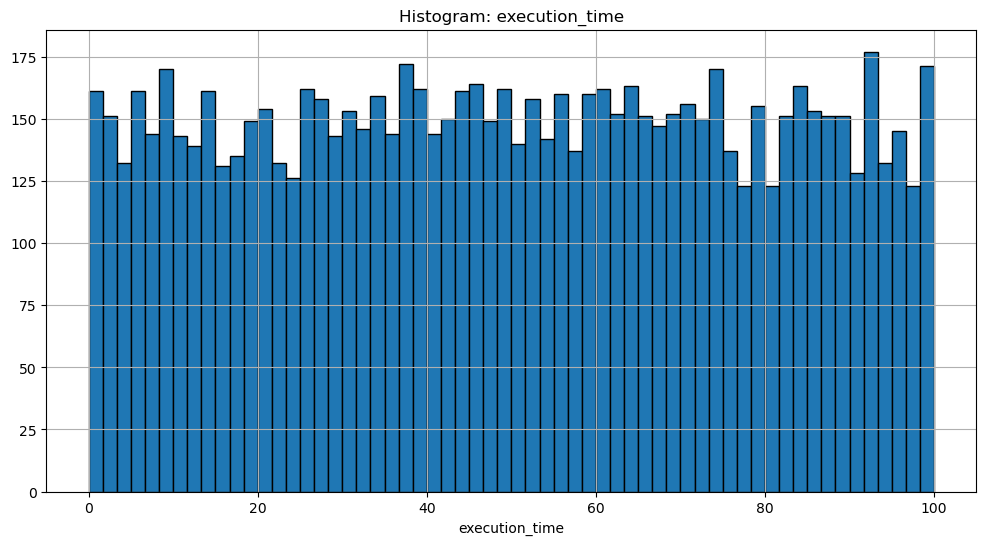

In [6]:
plt.figure(figsize=(12, 6))
plt.hist(df_sample['execution_time'].dropna(), bins=60, edgecolor='black')
plt.title('Histogram: execution_time')
plt.xlabel('execution_time')
plt.grid(True)
plt.show()

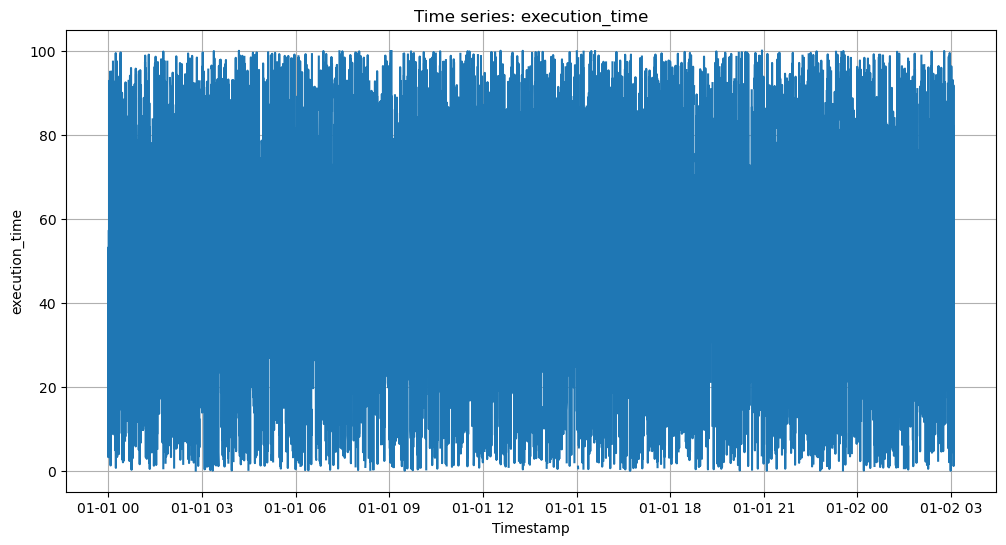

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(df_sample['timestamp'], df_sample['execution_time'])
plt.title('Time series: execution_time')
plt.xlabel('Timestamp')
plt.ylabel('execution_time')
plt.grid(True)
plt.show()

#### Forecasting of execution_time

Predicting task execution time in cloud computing environments is crucial for optimal resource management, task scheduling and ensuring high system performance
- Quality of service - more accurate execution time prediction leads to faster response times and better user experience
- Task scheduling - enables efficient task queuing, reducing waiting times and improving throughput
- Resource optimization - knowing the expected execution time, the system can better allocate CPU, memory and energy, avoiding overloads
- Reduction of costs - better management of server uptime leads to energy and financial savings

Models used: linear regression, random forest regressor, gradient boosting regressor

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap

C:\Users\piotr\anaconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Data preparation:
- Removing rows without execution_time value
- Removing vm_id and timestamp columns, because they are not important for prediction
- Removing the rest of missing data for simplicity

In [9]:
df = df_sample
df = df.dropna(subset=["execution_time"])
df = df.drop(columns=["vm_id", "timestamp"])
df = df.dropna()

##### Creating new features:
- Number of instructions executed per second - instructions_per_sec
- Amount of energy used to execute one instruction - energy_per_instruction

In [10]:
df["instructions_per_sec"] = df["num_executed_instructions"] / df["execution_time"]
df["energy_per_instruction"] = df["power_consumption"] / df["num_executed_instructions"]

##### Division of data into features and target:
- Variable that we want to predict - y
- All other inputs without target - X

In [11]:
y = df["execution_time"]
X = df.drop(columns=["execution_time"])

##### Division of columns into categorical and numeric:
- Categorical columns: task_type, task_priority, task_status
- Numerical columns: all the rest

In [12]:
categorical_cols = ["task_type", "task_priority", "task_status"]
numerical_cols = [col for col in X.columns if col not in categorical_cols]

##### Data preprocessing:
- Scaling of numerical features
- One-hot encoding of categorical features

In [13]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

##### Splitting data into training and test sets:
- Training set: 80% of data
- Test set: 20% of data
- For repeatability of results: random_state=42

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Linear regression

##### Linear regression model:
- Pipeline: preprocessor than regressor
- Machine learning model: LinearRegression

In [15]:
model_lr = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

##### Linear regression evaluation:
- Mean prediction error: RMSE
- Match factor: R^2

In [16]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2 = r2_score(y_test, y_pred_lr)
print(f"RMSE = {rmse:.5f}, R^2 = {r2:.5f}")

RMSE = 28.24143, R^2 = 0.01603


##### Linear regression visualization:
- Real vs predicted values plot
- X-axis: real value from y_test
- Y-axis: predicted value from y_pred_lr
- Red line: perfect fit

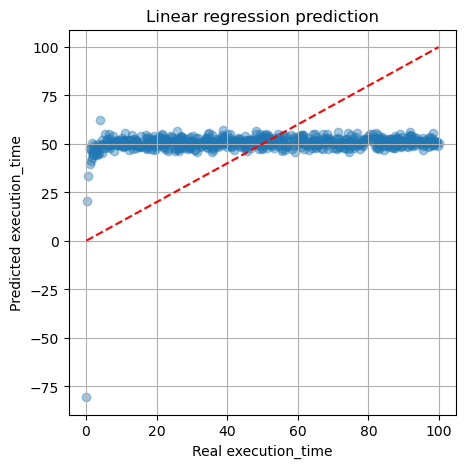

In [17]:
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred_lr, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Real execution_time")
plt.ylabel("Predicted execution_time")
plt.title("Linear regression prediction")
plt.grid(True)
plt.show()

##### Linear regression prediction conclusions:
- Very large error relative to execution_time scale
- Data has nonlinear relationships that the linear model does not capture

#### Random forest regressor

##### Random forest regressor model:
- Pipeline: preprocessor than regressor
- Machine learning model: RandomForestRegressor

In [18]:
model_rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

##### Random forest regressor evaluation:
- Mean prediction error: RMSE
- Match factor: R^2

In [19]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)
print(f"RMSE = {rmse:.5f}, R^2 = {r2:.5f}")

RMSE = 4.26930, R^2 = 0.97751


##### Random forest regressor visualization:
- Real vs predicted values plot
- X-axis: real value from y_test
- Y-axis: predicted value from y_pred_rf
- Red line: perfect fit

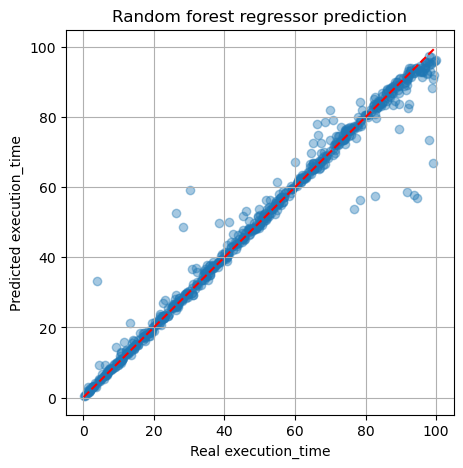

In [20]:
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred_rf, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Real execution_time")
plt.ylabel("Predicted execution_time")
plt.title("Random forest regressor prediction")
plt.grid(True)
plt.show()

##### Random forest feature importances
- Extracting regressor from pipeline
- Extracting feature names after transformation
- Generating SHAP plot with feature importance

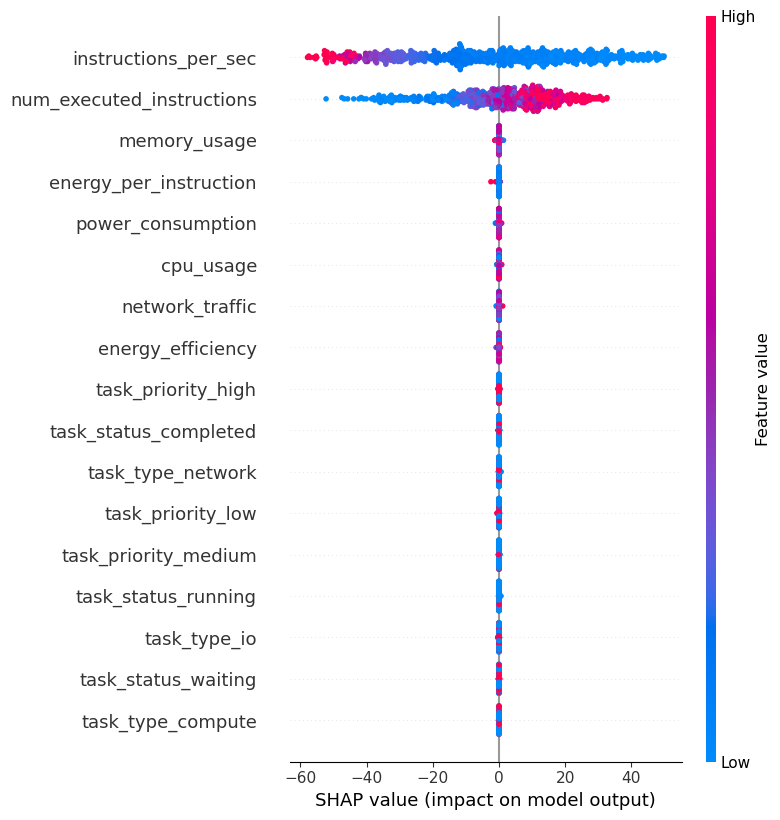

In [21]:
on_hot_encoder = model_rf.named_steps["preprocessor"].named_transformers_["cat"]
cat_features = on_hot_encoder.get_feature_names_out(input_features=categorical_cols)
all_features = numerical_cols + list(cat_features)

X_transformed = model_rf.named_steps["preprocessor"].transform(X_test)

explainer = shap.TreeExplainer(model_rf.named_steps["regressor"])
shap_values = explainer.shap_values(X_transformed)

shap.summary_plot(shap_values, X_transformed, feature_names=all_features)

##### Random forest regressor prediction conclusions:
- Very low error relative to execution_time scale
- Model copes well with nonlinearities and feature interactions
- Execution time depends mostly on instructions_per_sec and num_executed_instructions

#### Gradient boosting regressor

##### Gradient boosting regressor model:
- Pipeline: preprocessor than regressor
- Machine learning model: GradientBoostingRegressor

In [22]:
model_gb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", GradientBoostingRegressor(random_state=42))
])
model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_test)

##### Gradient boosting regressor evaluation:
- Mean prediction error: RMSE
- Match factor: R^2

In [23]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2 = r2_score(y_test, y_pred_gb)
print(f"RMSE = {rmse:.5f}, R^2 = {r2:.5f}")

RMSE = 5.24746, R^2 = 0.96603


##### Gradient boosting regressor visualization:
- Real vs predicted values plot
- X-axis: real value from y_test
- Y-axis: predicted value from y_pred_gb
- Red line: perfect fit

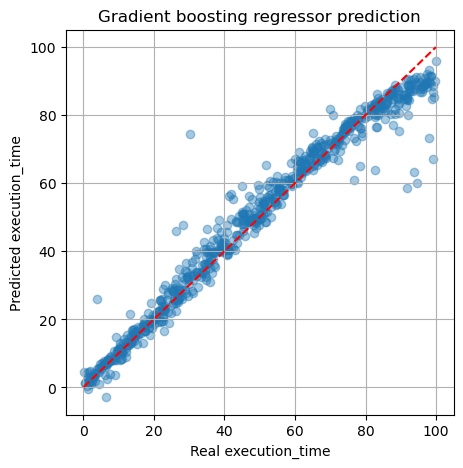

In [24]:
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred_gb, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Real execution_time")
plt.ylabel("Predicted execution_time")
plt.title("Gradient boosting regressor prediction")
plt.grid(True)
plt.show()

##### Gradient boosting regressor prediction conclusions:
- Error is similarly small as in the case of random forest
- Model copes well with nonlinearities, but slightly worse than random forest

#### Summary and conclusions
- Linear regression model proved to be insufficient because it was unable to capture nonlinear relationships in this data
- Tree-based models like random forest or gradient boosting are effective in predicting execution time with high accuracy
- Task execution time can be successfully estimated based on a set of cloud system performance metrics
- Predicting execution time can significantly help in resource optimization, task queuing and increasing energy efficiency in cloud environments